# Praca licencjacka - część empiryczna (koronawirus)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels as sm
from scipy import stats
from scipy.stats.distributions import chi2
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA

In [3]:
dane = pd.read_csv("time_series_covid19_confirmed_global.csv")
kopia = dane.copy()
dane.head(5)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,22,22,24,24,40,40,74,84,94,110
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,59,64,70,76,89,104,123,146,174,186
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,74,87,90,139,201,230,264,302,367,409
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,39,53,75,88,113,133,164,188,224,267
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,0,0,1,2,2,3,3,3,4,4


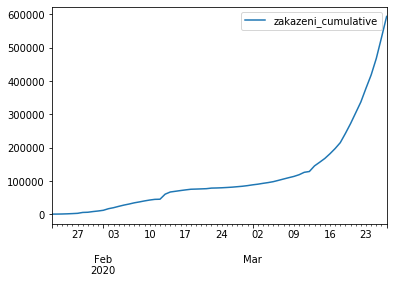

In [7]:
#patrzymy na caly swiat, najwiecej danych
daty = dane.columns[4:]
index = pd.DatetimeIndex(daty)
n = len(index)
swiat = dane.drop(["Province/State","Country/Region", "Lat", "Long"], axis= 1)
swiat = pd.DataFrame(data = swiat.sum(axis=0), columns = [ "zakazeni_cumulative"],index=index)
swiat.plot()
plt.show()


In [8]:
#dodaje x i lnx do danych, x - dzienna liczba nowych przypadkow
x = []
x.append(0)
for i in range(n-1):
    x.append(swiat.iloc[i+1,0]-swiat.iloc[i,0])

x[0]=int(np.random.uniform(low=1,high=x[1],size=1))
swiat["x"] = x
swiat["lnx"] = np.log(swiat["x"])

#dodaje pierwsze roznice dla logarytmow
x = []
x.append(0)
for i in range(n-1):
    x.append(np.log(swiat.iloc[i+1,1]/swiat.iloc[i,1]))
swiat["dlnx"] = x

#pierwsze roznice
x = []
x.append(0)
for i in range(n-1):
    x.append(swiat.iloc[i+1,1]-swiat.iloc[i,1])
swiat["dx"] = x

#drugie roznice
x = []
x.append(0)
for i in range(n-1):
    x.append(swiat.iloc[i+1,4]-swiat.iloc[i,4])

swiat["ddx"] = x



swiat

,zakazeni_cumulative,x,lnx,dlnx,dx,ddx
2020-01-22,555,74,4.304065,0.000000,0,0
2020-01-23,654,99,4.595120,0.291055,25,25
2020-01-24,941,287,5.659482,1.064362,188,163
2020-01-25,1434,493,6.200509,0.541027,206,18
2020-01-26,2118,684,6.527958,0.327449,191,-15
...,...,...,...,...,...,...
2020-03-23,378235,41282,10.628182,0.237434,8725,8529
2020-03-24,418045,39810,10.591873,-0.036308,-1472,-10197
2020-03-25,467653,49608,10.811907,0.220034,9798,11270
2020-03-26,529591,61938,11.033889,0.221982,12330,2532


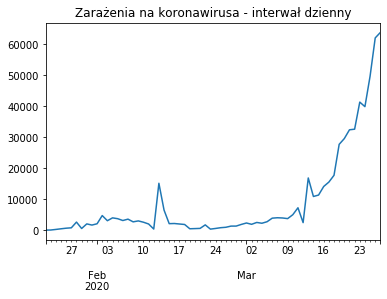

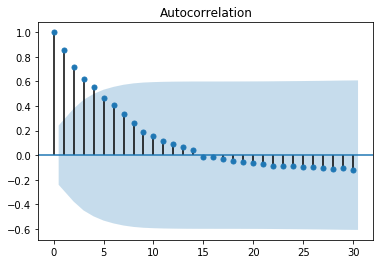

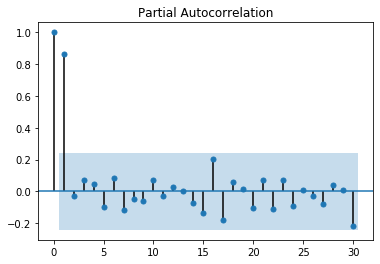

In [6]:

swiat["x"].plot()
plt.title("Zarażenia na koronawirusa - interwał dzienny")
#plt.savefig(fname="wykresy\korona1.jpg")
plt.show()

plot_acf(swiat["x"], lags=30)
#plt.savefig(fname="D:\Studia\Praca licencjacka - UJ\Tekst\korona_2.jpg")
plt.show()
plot_pacf(swiat["x"], lags=30)
#plt.savefig(fname="D:\Studia\Praca licencjacka - UJ\Tekst\korona_3.jpg")
plt.show()


## Analiza wartości dziennych zachorowań (x)

### Testy ADF

In [9]:
#ramka dancyh na zapisywanie wynikow
adf = pd.DataFrame()
adf["Index"]= ["drugie różnice", "pierwsze różnice"]
adf["W. stat. testowej"] = 0
adf["Pvalue"] = 0
adf["W. krytyczna (alfa=0.05)"]=0
adf

,Index,W. stat. testowej,Pvalue,W. krytyczna (alfa=0.05)
0,drugie różnice,0,0,0
1,pierwsze różnice,0,0,0


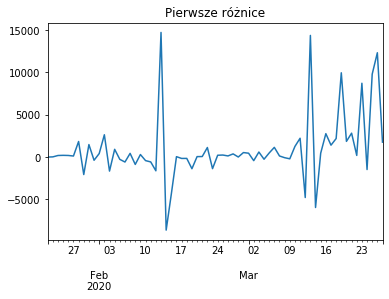

ADF Statistic: 2.496035
p-value: 0.999049
lag number 9
Critical Values:
	1%: -3.553
	5%: -2.915
	10%: -2.595


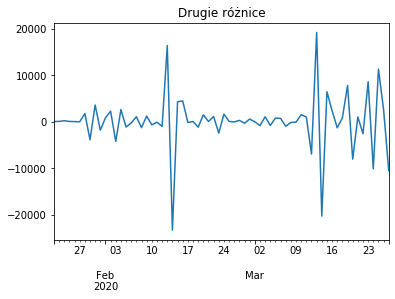

ADF Statistic: -5.578149
p-value: 0.000001
lag number 6
Critical Values:
	1%: -3.546
	5%: -2.912
	10%: -2.594


In [10]:
#pierwsze roznice


swiat["dx"].plot()
plt.title("Pierwsze różnice")
#plt.savefig(fname="D:\Studia\Praca licencjacka - UJ\Tekst\\korona_r.jpg")
plt.show() 

result = adfuller(swiat["dx"])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])#szereg nie jest stacjonarny
print("lag number", result[2])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
adf.iloc[1,1]=round(result[0],2)
adf.iloc[1,2]=result[1]
adf.iloc[1,3]=round(result[4]["5%"],2)


#drugie roznice

swiat["ddx"].plot()
plt.title("Drugie różnice")
plt.savefig(fname="D:\Studia\Praca licencjacka - UJ\Tekst\korona_rr.jpg")
plt.show() 

from statsmodels.tsa.stattools import adfuller
result = adfuller(swiat["ddx"])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])#szereg jest stacjonarny
print("lag number", result[2])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
adf.iloc[0,1]=round(result[0],2)
adf.iloc[0,2]=result[1]
adf.iloc[0,3]=round(result[4]["5%"],2)
#adf.to_latex("D:/Studia/Praca licencjacka - UJ/Tekst/test_adf.tex",index=False)

### Wybor modelu (kryterium AIC)

In [11]:
wyniki = pd.DataFrame()
wyniki["p"] = np.repeat(np.array([0,1,2,3]),4)
wyniki["q"] = [i%4 for i in range(16)]
wyniki["loglikelihood"]=0
wyniki["AIC"] = 0
#wyniki["BIC"] = 0
#wyniki["HQIC"] = 0 
n=0
for i in range(4):
    for j in range(4):
        model = ARIMA(swiat["x"][:60], order=(i,2,j))
        result = model.fit(start_params=np.zeros(i+j+1))
        wyniki.iloc[n,2] = round(result.llf,3)
        wyniki.iloc[n,3] = round(result.aic,3)
        #wyniki.iloc[n,4] = round(result.bic,1)
        #wyniki.iloc[n,5] = round(result.hqic,1)
        n+=1
        #print(model.score(params= result.params))
        #print(result.mle_retvals)
        #print(result.arparams, result.maparams)
        #print("Kryterium AIC dla modelu ARMA(",i,",",j,") wynosi",round(result.aic,2))
wyniki.drop(wyniki.index[0],axis=0,inplace=True)
#wyniki.to_latex("D:\Studia\Praca licencjacka - UJ\Tekst\criterion_aic.tex")


wyniki

C:\Programmy\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Programmy\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Programmy\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Programmy\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Programmy\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Programmy\Anaconda\lib\site

,p,q,loglikelihood,AIC
1,0,1,-557.089,1120.178
2,0,2,-549.842,1107.683
3,0,3,-549.639,1109.278
4,1,0,-569.474,1144.949
5,1,1,-552.436,1112.872
6,1,2,-549.613,1109.225
7,1,3,-549.045,1110.089
8,2,0,-560.176,1128.351
9,2,1,-550.836,1111.671
10,2,2,-549.576,1111.153


### Test(y) loglikehood-ratio


In [12]:
def LR(a,b):#a-liczba parametrow ogolnego modelu, b-liczba parametrow zagniezdzonego modelu
    lmax = float(wyniki[(wyniki["p"]==a[0]) & (wyniki["q"]==a[1])]["loglikelihood"])
    lmin = float(wyniki[(wyniki["p"]==b[0]) & (wyniki["q"]==b[1])]["loglikelihood"])
    S  =2*(lmax-lmin)
    pvalue = 1-chi2.cdf(S , sum(a)-sum(b))
    #print("pvalue jest rowne", pvalue, "dla modelu ARMA",b)
    return pvalue

In [13]:
#ranka danych do zapisywania wynikow
lrset = pd.DataFrame()
lista=[]
for i in range(4):
    for j in range(4):
        if (i==0) & (j==0)| ((i==3) & (j==3)):
            pass
        else:
            lista.append((i,j))
lrset["(p,q)"] = lista
lrset

,"(p,q)"
0,"(0, 1)"
1,"(0, 2)"
2,"(0, 3)"
3,"(1, 0)"
4,"(1, 1)"
5,"(1, 2)"
6,"(1, 3)"
7,"(2, 0)"
8,"(2, 1)"
9,"(2, 2)"


In [14]:
#test dla ARMA(3,3)
lrset["ARMA(3,3)"] = 0
k=0
for i in range(4):
    for j in range(4):
        if ((i==0) & (j==0))  | ((i==3) & (j==3)):
            pass

        else:
            lrset.loc[k,"ARMA(3,3)"] = LR((3,3),(i,j))
            k+=1


In [15]:
#test dla AMRA(1,3)
k=0
lrset["ARMA(1,3)"]=0
for i in range(2):
    for j in range(4):
        if ((i==0) & (j==0))  | ((i==1) & (j==3)):
            pass

        else:
            lrset.loc[k,"ARMA(1,3)"] = LR((1,3),(i,j))
            k+=1

In [16]:
#test dla AMRA(0,3)
k=0
lrset["ARMA(0,3)"]=0
for i in range(1):
    for j in range(4):
        if ((i==0) & (j==0))  | ((i==0) & (j==3)):
            pass

        else:
            lrset.loc[k,"ARMA(0,3)"] = LR((0,3),(i,j))
            k+=1

In [17]:
#test dla AMRA(0,2)
k=0
lrset["ARMA(0,2)"]=0
for i in range(1):
    for j in range(3):
        if ((i==0) & (j==0))  | ((i==0) & (j==2)):
            pass

        else:
            lrset.loc[k,"ARMA(0,2)"] = LR((0,2),(i,j))
            k+=1

In [18]:
lrset.replace(to_replace=0, value="-", inplace=True)
#lrset.to_latex("D:\Studia\Praca licencjacka - UJ\Tekst\lr_tests.tex",index=False)
lrset

,"(p,q)","ARMA(3,3)","ARMA(1,3)","ARMA(0,3)","ARMA(0,2)"
0,"(0, 1)",6.444750e-03,0.00108783,0.000581442,0.000140607
1,"(0, 2)",7.997789e-01,0.450679,0.524007,-
2,"(0, 3)",7.424718e-01,0.275733,-,-
3,"(1, 0)",9.765704e-08,7.00875e-09,-,-
4,"(1, 1)",1.447009e-01,0.033675,-,-
5,"(1, 2)",7.549237e-01,0.286499,-,-
6,"(1, 3)",9.723884e-01,-,-,-
7,"(2, 0)",1.732231e-04,-,-,-
8,"(2, 1)",3.033001e-01,-,-,-
9,"(2, 2)",5.717806e-01,-,-,-


### Najlepszy model, prognozy

In [19]:
model = ARIMA(swiat["x"][:60].astype('float32'), order=(0,2,2)).fit()


arma02_summary = model.summary2().tables
  
model.summary()
#with open("D:\Studia\Praca licencjacka - UJ\Tekst\summary_arma02.tex", 'w') as f:
#    f.write(model.summary().as_latex())

C:\Programmy\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Programmy\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                   D2.x   No. Observations:                   58
Model:                 ARIMA(0, 2, 2)   Log Likelihood                -549.842
Method:                       css-mle   S.D. of innovations           3087.285
Date:                Fri, 11 Sep 2020   AIC                           1107.683
Time:                        11:13:23   BIC                           1115.925
Sample:                    01-24-2020   HQIC                          1110.893
                         - 03-21-2020                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         60.6029     48.920      1.239      0.215     -35.279     156.485
ma.L1.D2.x    -1.5169      0.127    -11.915      0.000      -1.766      -1.267
ma.L2.D2.x     0.6302      0.129      4.880      0.000       0.377       0.883
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.2035           -0.3720j            1.2597           -0.0477
MA.2            1.2035           +0.3720j            1.2597            0.0477
-----------------------------------------------------------------------------
"""

In [21]:
#model.plot_predict(start="2020-01-24",end="2020-03-27",exog=swiat["x"][60:].astype('float32'), plot_insample=False).shape()

In [22]:
"""
#reprezentacja MA dla ARMA
var_e = model.sigma2
model.predict(start =2,end =4)
print(((1 + 2.5168784**2 + model.maparams[1]**2)*var_e)**0.5)
print(model.maparams)
arma_process = sm.tsa.arima_process.ArmaProcess([1],[1,-1.5168784,   0.63020014])
arma_process.arma2ma(lags=10)
sm.tsa.arima_process.arma_impulse_response([1],[1,-1.5168784,   0.63020014], leads=100)
model.arparams
"""

8584.557185059613
[-1.51687096  0.63017812]


array([], dtype=float64)

In [70]:
#obliczam "recznie" sigma2, ale w takich jednostakch jak chce (nominalnych),
#uzyje tego potem zeby wyliczyc nominalny blad prognozy (a raczej jego wariancje)

s_1 = model.sigma2**0.5
s_2 = (sum((model.predict(start = "2020-01-24",end ="2020-03-21", 
    typ="levels")-swiat.x[2:60])**2)/58)**0.5
s_1,s_2

(3087.2909130444373, 3089.0333691251203)

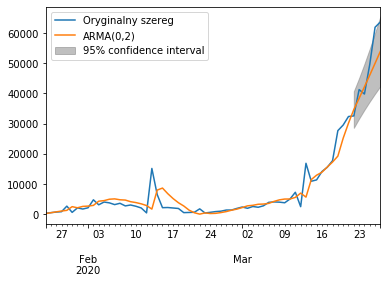

,22.03,23.03,24.03,25.03,26.03,27.03
wartości rzeczywiste,32557.0,41282.0,39810.0,49608.0,61938.0,63700.0
wartości prognozowane,34654.0,38397.0,42200.0,46064.0,49988.0,53973.0
błąd standardowy,3089.0,3431.0,3894.0,4469.0,5141.0,5899.0


In [77]:
#wykres z prognozami

fig, ax = plt.subplots()
ax = swiat['x'][2:].plot(ax=ax)
#fig = model.plot_predict(start="2020-01-24",end="2020-03-22",exog=swiat["x"][60:61], ax=ax, plot_insample=False)
model.plot_predict(start="2020-01-24",end="2020-03-27",exog=swiat["x"][60:], ax=ax, plot_insample=False)
ax.legend(["Oryginalny szereg", "ARMA(0,2)", "95% confidence interval"])
plt.savefig(fname="D:\Studia\Praca licencjacka - UJ\Tekst\korona_prognoza.jpg")
plt.show()

w_rzeczywiste = swiat["x"][60:]
w_prognozowane = model.forecast(steps=6)[0]
blad_prognozy = model.forecast(steps=6)[1]
prognoza_df = pd.DataFrame(data = np.around(np.array([w_rzeczywiste, w_prognozowane,blad_prognozy/s_1*s_2]),0), 
                           columns = ["22.03","23.03","24.03","25.03","26.03","27.03"],
                           index = ["wartości rzeczywiste","wartości prognozowane","błąd standardowy"])


#prognoza_df.to_latex("D:\Studia\Praca licencjacka - UJ\Tekst\prognoza_blad")
prognoza_df

In [43]:
s_1 = model.sigma2**0.5
s_2 = (sum((model.predict(start = "2020-01-24",end ="2020-03-21", 
    typ="levels")-swiat.x[2:60])**2)/58)**0.5
s_1,s_2

(3087.2909130444373, 3089.0333691251203)

## Analiza logarytmow dziennych zachorowan (lnx)

p-value: 0.863186
lag number 3


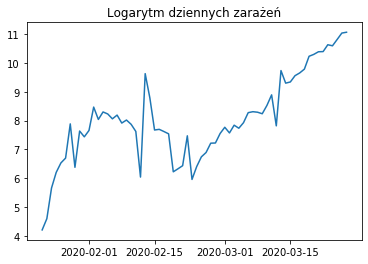

p-value: 0.000000
lag number 1


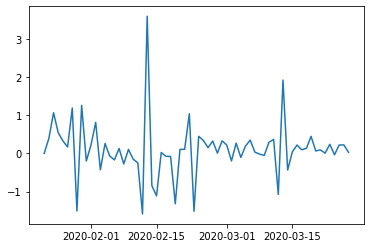

In [75]:
result = adfuller(swiat["lnx"])

print('p-value: %f' % result[1])#szereg nie jest stacjonarny
print("lag number", result[2])
plt.plot(swiat.lnx)
plt.title("Logarytm dziennych zarażeń")
plt.savefig(fname="D:\Studia\Praca licencjacka - UJ\Tekst\korona_log.jpg")
plt.show()
plt.plot(swiat.dlnx)
result = adfuller(swiat.dlnx, maxlag=3)

print('p-value: %f' % result[1])#szereg stacjonarny
print("lag number", result[2])
plt.show()

In [25]:
model_log = ARIMA(swiat["lnx"][:60], order=(0,2,2)).fit(start_params=np.zeros(3))


arma02_summary = model_log.summary2().tables
  
model_log.summary()
#with open("D:\Studia\Praca licencjacka - UJ\Tekst\summary_arma02_log.tex", 'w') as f:
#    f.write(model.summary().as_latex())

C:\Programmy\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Programmy\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D2.lnx   No. Observations:                   58
Model:                 ARIMA(0, 2, 2)   Log Likelihood                 -62.349
Method:                       css-mle   S.D. of innovations              0.691
Date:                Thu, 11 Jun 2020   AIC                            132.699
Time:                        10:00:34   BIC                            140.941
Sample:                    01-24-2020   HQIC                           135.909
                         - 03-21-2020                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0054      0.010     -0.532      0.595      -0.025       0.014
ma.L1.D2.lnx    -1.4968      0.108    -13.898      0.000      -1.708      -1.286
ma.L2.D2.lnx     0.6013      0.101      5.971      0.000       0.404       0.799
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.2446           -0.3376j            1.2895           -0.0422
MA.2            1.2446           +0.3376j            1.2895            0.0422
-----------------------------------------------------------------------------
"""

In [66]:
#obliczam "recznie" sigma2, ale w takich jednostakch jak chce (nominalnych),
#uzyje tego potem zeby wyliczyc nominalny blad prognozy (a raczej jego wariancje)

s_log1 = model_log.sigma2**0.5
s_log2 = (sum((np.exp(model_log.predict(start = "2020-01-24",end ="2020-03-21", 
    typ="levels"))-swiat.x[2:60])**2)/58)**0.5



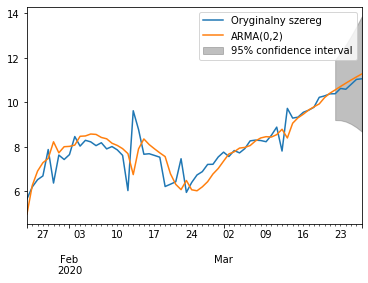

,22.03,23.03,24.03,25.03,26.03,27.03
wartości rzeczywiste,32557.00,41282.00,39810.00,49608.00,61938.00,63700.00
wartości prognozowane,38631.03,45058.77,52274.85,60322.14,69235.88,79041.70
błąd standardowy,2952.09,3304.72,3760.19,4308.00,4936.70,5636.12


In [78]:
#wykres z prognozami

fig, ax = plt.subplots()
ax = swiat['lnx'][2:].plot(ax=ax)
fig = model_log.plot_predict(start="2020-01-24",end="2020-03-27",exog=swiat["lnx"][60:], ax=ax, plot_insample=False)
ax.legend(["Oryginalny szereg", "ARMA(0,2)", "95% confidence interval"])
plt.savefig(fname="D:\Studia\Praca licencjacka - UJ\Tekst\korona_prognoza_log.jpg")
plt.show()

w_rzeczywiste = swiat["lnx"][60:]
w_prognozowane = model_log.forecast(steps=6)[0]
blad_prognozy = model_log.forecast(steps=6)[1]
prognoza_df = pd.DataFrame(data = np.around(np.array([np.exp(w_rzeczywiste), np.exp(w_prognozowane),blad_prognozy/s_log1*s_log2]),2), 
                           columns = ["22.03","23.03","24.03","25.03","26.03","27.03"],
                           index = ["wartości rzeczywiste","wartości prognozowane","błąd standardowy"])


prognoza_df.to_latex("D:\Studia\Praca licencjacka - UJ\Tekst\prognoza_blad_log")
prognoza_df

## Recznie obliczone wartosci rmse (blad prognozy ex post)

In [28]:
bledy_log = []

for i in range(6):
    bledy_log.append((sum((np.exp(model_log.predict(start = "2020-01-24",end =60+i,  exog = swiat.lnx[60:61+i],
    typ="levels")) -np.array(swiat.x[2:61+i]))**2)/(60+i))**0.5)


In [29]:
bledy = []

for i in range(6):
    bledy.append((sum((model.predict(start = "2020-01-24",end =60+i,  exog = swiat.lnx[60:61+i],
    typ="levels") -np.array(swiat.x[2:61+i]))**2)/(60+i))**0.5)

In [24]:
rmse = (sum((model.predict(start = "2020-01-24",end ="2020-03-22",  exog = swiat.x[60:61],   typ="levels") -
     np.array(swiat.x[2:61]))**2)/59)**0.5
rmse

3074.8891578162456